# <center> **Premier League Season Simulator** </center>


### Set Up

In [66]:
# Load necessary libraries
library(gtools)   # for permutations
library(dplyr)
library(ggplot2)
library(gridExtra)
library(kableExtra)
library(IRdisplay)
library(rootSolve)

# Load your data
team_estim <- read.csv("TeamEstim.csv", stringsAsFactors = FALSE)


Warning message:
"package 'rootSolve' was built under R version 4.2.3"


## Simulate Seasons

### Figure Out Single Season First

In [76]:
head(team_estim)

,team,alpha,delta,XG,XGA
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Arsenal,0.282524652,0.664408836,1.761972,0.6835198
2,Aston Villa,0.127861566,-0.044037071,1.509488,1.3881143
3,Bournemouth,0.009977517,0.023868964,1.341632,1.2969822
4,Brentford,0.055149116,-0.097188167,1.403625,1.4638901
5,Brighton,0.052443727,-0.009484941,1.399833,1.3409712
6,Chelsea,0.264157343,0.011395550,1.729905,1.3132613


In [2]:



# Set up alpha and delta as named vectors
alphaList <- setNames(team_estim$alpha, team_estim$team)
deltaList <- setNames(team_estim$delta, team_estim$team)

# Function to simulate a single match
draw.score <- function(team1, team2) {
  c(
    rpois(1, exp(alphaList[team1] - deltaList[team2])),
    rpois(1, exp(alphaList[team2] - deltaList[team1]))
  )
}

# Generate all matchups (home and away)
allMatches <- permutations(n = length(team_estim$team), r = 2, v = team_estim$team)
colnames(allMatches) <- c("home", "away")

# Simulate each match
ScoresMatrix <- matrix(nrow = nrow(allMatches), ncol = 4)
for (ii in 1:nrow(allMatches)) {
  ScoresMatrix[ii, 1:2] <- allMatches[ii, ]
  ScoresMatrix[ii, 3:4] <- draw.score(allMatches[ii, "home"], allMatches[ii, "away"])
}
colnames(ScoresMatrix) <- c("home.team", "away.team", "home.score", "away.score")

# Convert to data frame for further analysis
ScoresDF <- as.data.frame(ScoresMatrix, stringsAsFactors = FALSE)
ScoresDF$home.score <- as.numeric(ScoresDF$home.score)
ScoresDF$away.score <- as.numeric(ScoresDF$away.score)

# View results
head(ScoresDF)
nrow(ScoresDF)

# No Repeats 
    # 20*38 = 760, but do not recount because teams play eachother
    # 760/2 = 380 total matches (with no repeats)


,home.team,away.team,home.score,away.score
,<chr>,<chr>,<dbl>,<dbl>
1,Arsenal,Aston Villa,3,0
2,Arsenal,Bournemouth,1,0
3,Arsenal,Brentford,2,1
4,Arsenal,Brighton,0,0
5,Arsenal,Chelsea,0,0
6,Arsenal,Crystal Palace,0,1


[1] 380

In [3]:
# Create New Column to identify weather the home or away team wins (or draws) by comparing the .score variables

ScoresDF <- ScoresDF %>%
  mutate(winner = case_when(
    home.score > away.score ~ "Home",
    home.score < away.score ~ "Away",
    home.score == away.score ~ "Draw"
  ))

In [4]:
head(ScoresDF)

,home.team,away.team,home.score,away.score,winner
,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,Arsenal,Aston Villa,3,0,Home
2,Arsenal,Bournemouth,1,0,Home
3,Arsenal,Brentford,2,1,Home
4,Arsenal,Brighton,0,0,Draw
5,Arsenal,Chelsea,0,0,Draw
6,Arsenal,Crystal Palace,0,1,Away


In [5]:
# Create a new column that prints the name of the winner
# We still have to figure out draws so we leave them alone for now

ScoresDF <- ScoresDF %>%
  mutate(winning_team = case_when(
    winner == "Home" ~ home.team,
    winner == "Away" ~ away.team,
    winner == "Draw" ~ "Draw"
  ))
head(ScoresDF)

,home.team,away.team,home.score,away.score,winner,winning_team
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,Arsenal,Aston Villa,3,0,Home,Arsenal
2,Arsenal,Bournemouth,1,0,Home,Arsenal
3,Arsenal,Brentford,2,1,Home,Arsenal
4,Arsenal,Brighton,0,0,Draw,Draw
5,Arsenal,Chelsea,0,0,Draw,Draw
6,Arsenal,Crystal Palace,0,1,Away,Crystal Palace


In [6]:
# Step 2: Count wins per team (exclude draws)
points_wins <- ScoresDF %>%
  filter(winning_team != "Draw") %>%
  count(winning_team, name = "wins") %>%
  mutate(win_points = wins * 3)

# Step 3: Count draws (both home and away teams)
draw_points_home <- ScoresDF %>%
  filter(winner == "Draw") %>%
  count(home.team, name = "draws_home")

draw_points_away <- ScoresDF %>%
  filter(winner == "Draw") %>%
  count(away.team, name = "draws_away")

points_wins
draw_points_home
draw_points_away

winning_team,wins,win_points
<chr>,<int>,<dbl>
Arsenal,21,63
Aston Villa,14,42
Bournemouth,10,30
Brentford,13,39
Brighton,15,45
Chelsea,19,57
Crystal Palace,16,48
Everton,10,30
Fulham,12,36


home.team,draws_home
<chr>,<int>
Arsenal,7
Aston Villa,6
Bournemouth,8
Brentford,6
Brighton,2
Chelsea,3
Crystal Palace,4
Everton,7
Fulham,1


away.team,draws_away
<chr>,<int>
Arsenal,5
Aston Villa,7
Bournemouth,3
Brentford,5
Brighton,7
Chelsea,2
Crystal Palace,9
Everton,5
Fulham,4


In [7]:
# Rename before joining to avoid column conflict
home_draws <- draw_points_home %>%
  rename(team = home.team)

away_draws <- draw_points_away %>%
  rename(team = away.team)

# Merge draws and sum them up
draw_points <- full_join(home_draws, away_draws, by = "team") %>%
  mutate(
    draws_home = coalesce(draws_home, 0),
    draws_away = coalesce(draws_away, 0),
    total_draws = draws_home + draws_away,
    draw_points = total_draws * 1
  ) %>%
  select(team, total_draws, draw_points)

# Prepare win table (already has winning_team)
points_wins <- points_wins %>%
  rename(team = winning_team)

# Combine win and draw points
points_table <- full_join(points_wins, draw_points, by = "team") %>%
  mutate(
    wins = coalesce(wins, 0),
    win_points = coalesce(win_points, 0),
    total_draws = coalesce(total_draws, 0),
    draw_points = coalesce(draw_points, 0),
    total_points = win_points + draw_points
  ) %>%
  select(team, wins, total_draws, total_points) %>%
  arrange(desc(total_points))

# View the final points table
print(points_table)



             team wins total_draws total_points
1        Man City   27           4           85
2       Newcastle   25           7           82
3         Arsenal   21          12           75
4       Liverpool   20          10           70
5         Chelsea   19           5           62
6  Crystal Palace   16          13           61
7     Aston Villa   14          13           55
8          Wolves   16           7           55
9        Brighton   15           9           54
10      Tottenham   15           9           54
11  Nott'm Forest   13          13           52
12     Man United   12          15           51
13      Brentford   13          11           50
14        Everton   10          12           42
15    Bournemouth   10          11           41
16         Fulham   12           5           41
17       West Ham    9          10           37
18        Ipswich    8           5           29
19    Southampton    5          10           25
20      Leicester    3          13      

In [8]:
# Convert to data frame
pt_df<- as.data.frame(points_table)

pt_df

team,wins,total_draws,total_points
<chr>,<dbl>,<dbl>,<dbl>
Man City,27,4,85
Newcastle,25,7,82
Arsenal,21,12,75
Liverpool,20,10,70
Chelsea,19,5,62
Crystal Palace,16,13,61
Aston Villa,14,13,55
Wolves,16,7,55
Brighton,15,9,54


### Simulate Many Seasons

In [9]:

# Create a function that joins all of our season simulation work above

simulate_season <- function(alphaList, deltaList, team_names) {
  # Draw a single match score
  draw.score <- function(team1, team2) {
    c(
      rpois(1, exp(alphaList[team1] - deltaList[team2])),
      rpois(1, exp(alphaList[team2] - deltaList[team1]))
    )
  }

  # All matches
  allMatches <- permutations(length(team_names), 2, v = team_names)
  colnames(allMatches) <- c("home", "away")

  # Simulate season
  ScoresMatrix <- matrix(nrow = nrow(allMatches), ncol = 4)
  for (ii in 1:nrow(allMatches)) {
    ScoresMatrix[ii, 1:2] <- allMatches[ii, ]
    ScoresMatrix[ii, 3:4] <- draw.score(allMatches[ii, "home"], allMatches[ii, "away"])
  }
  colnames(ScoresMatrix) <- c("home.team", "away.team", "home.score", "away.score")
  ScoresDF <- as.data.frame(ScoresMatrix, stringsAsFactors = FALSE)
  ScoresDF$home.score <- as.numeric(ScoresDF$home.score)
  ScoresDF$away.score <- as.numeric(ScoresDF$away.score)

  # Add result column
  ScoresDF$winner <- ifelse(
    ScoresDF$home.score > ScoresDF$away.score, "Home",
    ifelse(ScoresDF$home.score < ScoresDF$away.score, "Away", "Draw")
  )
  ScoresDF$winning_team <- ifelse(
    ScoresDF$winner == "Home", ScoresDF$home.team,
    ifelse(ScoresDF$winner == "Away", ScoresDF$away.team, "Draw")
  )

  # Count wins
  win_points <- ScoresDF %>%
    filter(winning_team != "Draw") %>%
    count(winning_team, name = "wins") %>%
    mutate(points = wins * 3)

  # Count draws
  draw_points_home <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(home.team, name = "draws_home") %>%
    rename(team = home.team)

  draw_points_away <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(away.team, name = "draws_away") %>%
    rename(team = away.team)

  draw_points <- full_join(draw_points_home, draw_points_away, by = "team") %>%
    mutate(
      draws_home = coalesce(draws_home, 0),
      draws_away = coalesce(draws_away, 0),
      total_draws = draws_home + draws_away,
      points = total_draws
    )

  # Combine win and draw points
  points_table <- full_join(
    win_points %>% rename(team = winning_team),
    draw_points, by = "team"
  ) %>%
    mutate(
      points.x = coalesce(points.x, 0),
      points.y = coalesce(points.y, 0),
      total_points = points.x + points.y
    ) %>%
    select(team, total_points)

  # Return total points per team for this season
  out <- setNames(points_table$total_points, points_table$team)
  return(out)
}


In [10]:
monte.carlo.sim<-function(fun,fun.arg,nSims=10000){
    # this line just runs fun(arguments in fun.arg list) so if fun.arg=(x,y,z) do.call(fun,fun.arg) runs fun(x,y,z)
    rep1<- do.call(fun,fun.arg) 
    # Set the dimensions for the output matrix
    nc<-length(rep1)
    lbl<-names(rep1)
    outputMatrix <- matrix(1,nrow=nSims, ncol=nc)
    outputMatrix[1, ]<-rep1 # write the sim to the first line
    for (rep in 2:nSims) { # for each of the remaining sims, add them in
        outputMatrix[rep, ] <- do.call(fun,fun.arg)
    }
    df<-data.frame(outputMatrix) # convert it to a data frame
    names(df)<-lbl  # get the names from the simulation output lbl
    return(df) # return the data frame as the output
}

In [11]:
# Prepare input data
alphaList <- setNames(team_estim$alpha, team_estim$team)
deltaList <- setNames(team_estim$delta, team_estim$team)
team_names <- team_estim$team

In [12]:
# Simulate 1000 seasons
season_sims <- monte.carlo.sim(
  fun = simulate_season,
  fun.arg = list(alphaList = alphaList, deltaList = deltaList, team_names = team_names),
  nSims = 1000
)

# Example: average points per team
colMeans(season_sims)

Arsenal    Aston Villa    Bournemouth      Brentford       Brighton 
        76.689         54.646         51.990         49.862         52.804 
       Chelsea Crystal Palace        Everton         Fulham        Ipswich 
        61.069         51.094         46.111         51.492         31.194 
     Leicester      Liverpool       Man City     Man United      Newcastle 
        26.982         76.595         74.018         50.077         59.751 
 Nott'm Forest    Southampton      Tottenham       West Ham         Wolves 
        51.947         22.722         59.106         43.436         44.078

In [13]:
# Create Df

# Calculate average points across all simulations
avg_points <- colMeans(season_sims)

# Convert to data frame
avg_points_df <- data.frame(
  team = names(avg_points),
  average_points = as.numeric(avg_points)
)

# Sort by highest average points
avg_points_df <- avg_points_df %>%
  arrange(desc(average_points))

# View result
head(avg_points_df)

,team,average_points
,<chr>,<dbl>
1,Arsenal,76.689
2,Liverpool,76.595
3,Man City,74.018
4,Chelsea,61.069
5,Newcastle,59.751
6,Tottenham,59.106


### Adding Revenue

In [14]:
# Hard code value of earnings and position

revenue_by_position <- data.frame(
  position = 1:20,
  revenue_million_gbp = c(
    149.6, 145.9, 142.1, 138.4, 73.7, 70.0, 55.2, 33.5, 29.8, 26.0,
    22.3, 18.6, 14.9, 11.2, 7.5, 3.7, 0, -88.7, -92.5, -96.2
  )
)

In [15]:
# Create an empty matrix to store revenue per team per season
revenue_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(revenue_matrix) <- colnames(season_sims)
rownames(revenue_matrix) <- 1:nrow(season_sims)

# Loop through each simulated season
for (i in 1:nrow(season_sims)) {
  season_points <- as.numeric(season_sims[i, ])
  names(season_points) <- colnames(season_sims)

  ranked_teams <- names(sort(season_points, decreasing = TRUE))

  # Assign revenue based on league position
  for (j in 1:20) {
    team <- ranked_teams[j]
    revenue_matrix[i, team] <- revenue_by_position$revenue_million_gbp[j]
  }
}


In [16]:
revenue_df <- as.data.frame(revenue_matrix)
head(revenue_df)

,Arsenal,Aston Villa,Bournemouth,Brentford,Brighton,Chelsea,Crystal Palace,Everton,Fulham,Ipswich,Leicester,Liverpool,Man City,Man United,Newcastle,Nott'm Forest,Southampton,Tottenham,West Ham,Wolves
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,149.6,70.0,7.5,29.8,22.3,18.6,26.0,0.0,33.5,-88.7,-92.5,145.9,138.4,55.2,73.7,14.9,-96.2,142.1,11.2,3.7
2,145.9,70.0,29.8,3.7,22.3,138.4,18.6,7.5,33.5,-88.7,-92.5,149.6,142.1,11.2,73.7,26.0,-96.2,55.2,14.9,0.0
3,149.6,11.2,7.5,29.8,22.3,73.7,14.9,26.0,18.6,-88.7,-96.2,145.9,142.1,3.7,70.0,0.0,-92.5,138.4,55.2,33.5
4,142.1,145.9,55.2,26.0,33.5,149.6,70.0,7.5,14.9,-92.5,-96.2,138.4,73.7,18.6,11.2,22.3,-88.7,29.8,3.7,0.0
5,145.9,138.4,22.3,55.2,26.0,142.1,14.9,11.2,18.6,0.0,-92.5,149.6,33.5,7.5,73.7,70.0,-96.2,29.8,3.7,-88.7
6,142.1,55.2,29.8,7.5,70.0,138.4,26.0,3.7,22.3,-96.2,-92.5,145.9,149.6,18.6,33.5,14.9,-88.7,73.7,11.2,0.0


In [17]:
# average the revenue of each team for all 1000 seasons
avg_revenue <- colMeans(revenue_df)

avg_revenue_df <- data.frame(
  team = names(avg_revenue),
  average_revenue_million = as.numeric(avg_revenue)
)

# Create the table
html_table<- avg_revenue_df %>%
  arrange(desc(average_revenue_million)) %>%
  mutate(
    average_revenue_million = round(average_revenue_million, 1)
  ) %>%
  kable("html", caption = "Average Revenue per Team (Simulated Seasons)",
        col.names = c("Team", "Average Revenue (GBP Millions)")) %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed", "responsive"),
                full_width = FALSE, position = "left")

# Display in Jupyter Notebook
display_html(as.character(html_table))


Team,Average Revenue (GBP Millions)
Arsenal,142.3
Liverpool,141.6
Man City,136.3
Chelsea,78.7
Newcastle,68.9
Tottenham,64.7
Aston Villa,45.7
Brighton,36.9
Bournemouth,34.7
Nott'm Forest,31.2


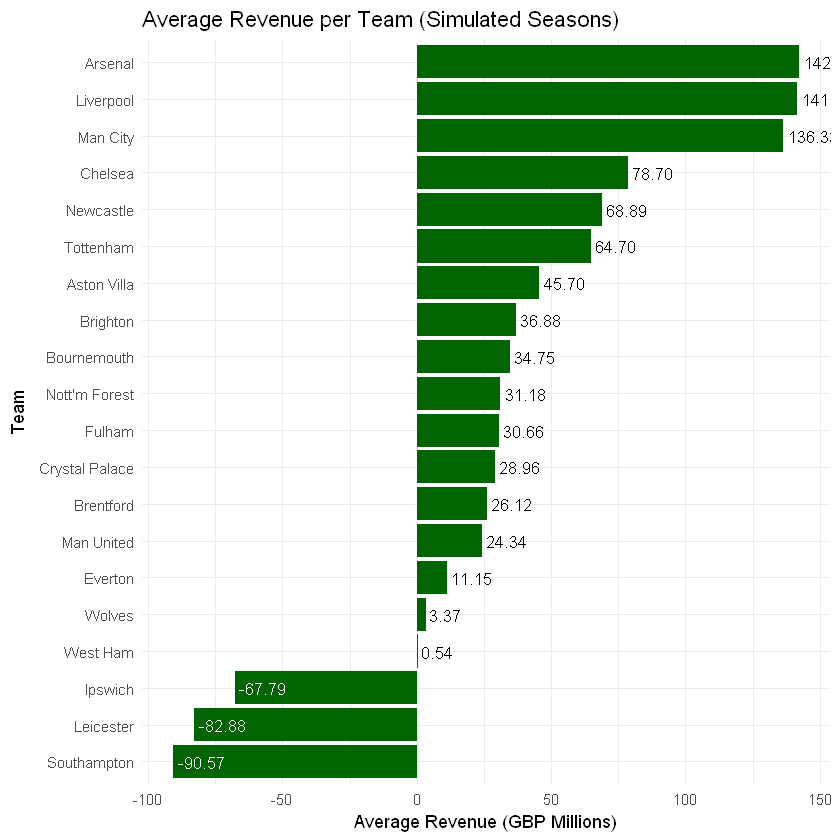

In [18]:
# Order teams by average revenue for clean plotting
avg_revenue_df$team <- factor(avg_revenue_df$team, levels = avg_revenue_df$team[order(avg_revenue_df$average_revenue_million)])

# Plot
p <- ggplot(avg_revenue_df, aes(x = team, y = average_revenue_million)) +
  geom_bar(stat = "identity", fill = "darkgreen") +
  coord_flip() +
  labs(
    title = "Average Revenue per Team (Simulated Seasons)",
    x = "Team",
    y = "Average Revenue (GBP Millions)"
  ) +
  geom_text(aes(
    label = scales::comma(average_revenue_million),
    color = ifelse(average_revenue_million < 0, "white", "black")  # Make negative numbers white
  ), hjust = -0.1, size = 3.5) +  # Add numbers to bars
  theme_minimal() +
  scale_color_identity()  # Ensure the color mapping is applied correctly

# Display the plot
print(p)

# Save the plot with higher resolution
ggsave("C:\\Users\\roryq\\Downloads\\avg_revenue_plot.png", plot = p, dpi = 300, width = 10, height = 6)


## Examine Variability

In [19]:
# Calculate average and standard deviation of revenue in sims
avg_revenue <- colMeans(revenue_df)
revenue_sd <- apply(revenue_df, 2, sd)

# Combine into one data frame
avg_revenue_df <- data.frame(
  team = names(avg_revenue),
  average_revenue_million = as.numeric(avg_revenue),
  sd_revenue = as.numeric(revenue_sd)
)

#  Arrange by highest SD and display top 8
top8_revenue_sd <- avg_revenue_df %>%
  arrange(desc(sd_revenue)) %>%
  head(8)

# Create and style the table
top8_table <- top8_revenue_sd %>%
  mutate(
    average_revenue_million = round(average_revenue_million, 1),
    sd_revenue = round(sd_revenue, 1)
  ) %>%
  kable("html", caption = "Most Variable Teams by Simulated Revenue (Top 8)",
        col.names = c("Team", "Avg Revenue (GBP M)", "Revenue SD (GBP M)")) %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed"),
                full_width = FALSE, position = "left")

# Render in Jupyter Notebook
display_html(as.character(top8_table))

Team,Avg Revenue (GBP M),Revenue SD (GBP M)
Tottenham,64.7,46.9
Chelsea,78.7,46.4
Newcastle,68.9,44.6
Ipswich,-67.8,41.1
Aston Villa,45.7,37.4
Brighton,36.9,36.2
Bournemouth,34.7,35.8
West Ham,0.5,35.4


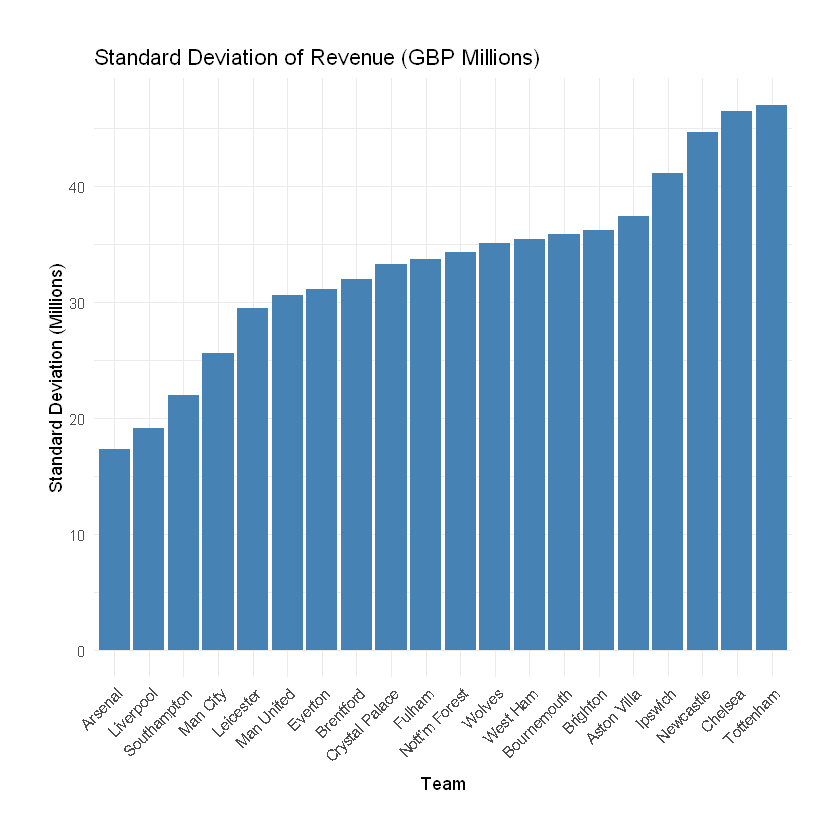

In [98]:
options(repr.plot.width = NULL, repr.plot.height = NULL)

# Step 1: Order the teams by sd_revenue
avg_revenue_df <- avg_revenue_df %>%
  arrange(sd_revenue)

# Step 2: Convert team column to a factor with levels in the desired order
avg_revenue_df$team <- factor(avg_revenue_df$team, levels = avg_revenue_df$team)



ggplot(avg_revenue_df, aes(x = team, y = sd_revenue)) +
  geom_bar(stat = "identity", fill = "steelblue") +
    # Round numbers and add above the bars
  labs(
    title = "Standard Deviation of Revenue (GBP Millions)",
    x = "Team",
    y = "Standard Deviation (Millions)"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  theme(
    plot.margin = margin(1, 1, 1, 1, "cm")  # Adds some space to avoid text cutoffs
  )

In [21]:
# Create Confidence Intervals

nSims <- 1000

avg_revenue_df <- avg_revenue_df %>%
  mutate(
    ci_lower = average_revenue_million - 1.96 * sd_revenue / sqrt(nSims),
    ci_upper = average_revenue_million + 1.96 * sd_revenue / sqrt(nSims)
  )


avg_revenue_df <- avg_revenue_df %>%
  arrange(desc(-average_revenue_million))

avg_revenue_df$team <- factor(avg_revenue_df$team, levels = avg_revenue_df$team)

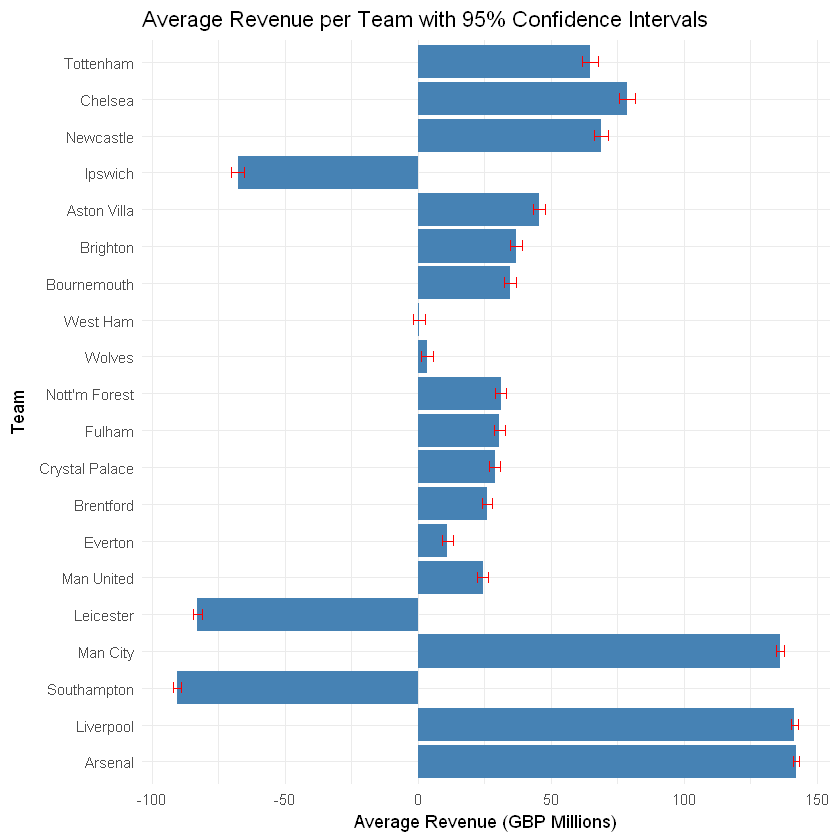

In [99]:
options(repr.plot.width = NULL, repr.plot.height = NULL)

# Plot average revenues with confidence intervals
ggplot(avg_revenue_df, aes(x = team, y = average_revenue_million)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_errorbar(
    aes(ymin = ci_lower, ymax = ci_upper),
    width = 0.3,
    color = "red"
  ) +
  coord_flip() +
  labs(
    title = "Average Revenue per Team with 95% Confidence Intervals",
    x = "Team",
    y = "Average Revenue (GBP Millions)"
  ) +
  theme_minimal()

## Benefits of a 'Lucky Win'

**Findings**

Teams that are more variable (from question 2) tend to benefit more from a lucky win. This is intuitive because they often sit on the edge of important cutoffs and 3-point bump can easily push them up or down several ranks, which means a big revenue swing. Leading to high variation, and marginal effect of a win

**Method**

+ In each simulated season (already simulated):

    + For every team, we simulate a lucky win by simply adding 3 points to their total — the amount they'd receive for winning a match.

    + All other teams' points remain unchanged.

    + We re-rank the league based on the new point totals and recalculate revenue.

    + We record the difference in revenue for that team before and after the bonus.
    
+ For all the teams we take average the marginal revenue difference to view marginal effect of randomly winning one more game.

+ 1,000 seasons × 20 teams = 20,000 simulations.

In [23]:
# Create matrix to hold marginal revenue gains
marginal_gain_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(marginal_gain_matrix) <- colnames(season_sims)

# Loop over each simulation
for (i in 1:nrow(season_sims)) {
  original_points <- as.numeric(season_sims[i, ])
  names(original_points) <- colnames(season_sims)
  
  original_ranking <- names(sort(original_points, decreasing = TRUE))
  original_revenue <- setNames(revenue_by_position$revenue_million_gbp, original_ranking)
  
  for (team in names(original_points)) {
    # Add 3 points (a "lucky win")
    new_points <- original_points
    new_points[team] <- new_points[team] + 3
    
    new_ranking <- names(sort(new_points, decreasing = TRUE))
    new_revenue <- setNames(revenue_by_position$revenue_million_gbp, new_ranking)
    
    # Revenue difference for this team only
    marginal_gain_matrix[i, team] <- new_revenue[team] - original_revenue[team]
  }
}


In [24]:
marginal_gain_avg <- colMeans(marginal_gain_matrix)

marginal_gain_df <- data.frame(
  team = names(marginal_gain_avg),
  marginal_revenue_gain = marginal_gain_avg
) %>%
  arrange(desc(marginal_revenue_gain))

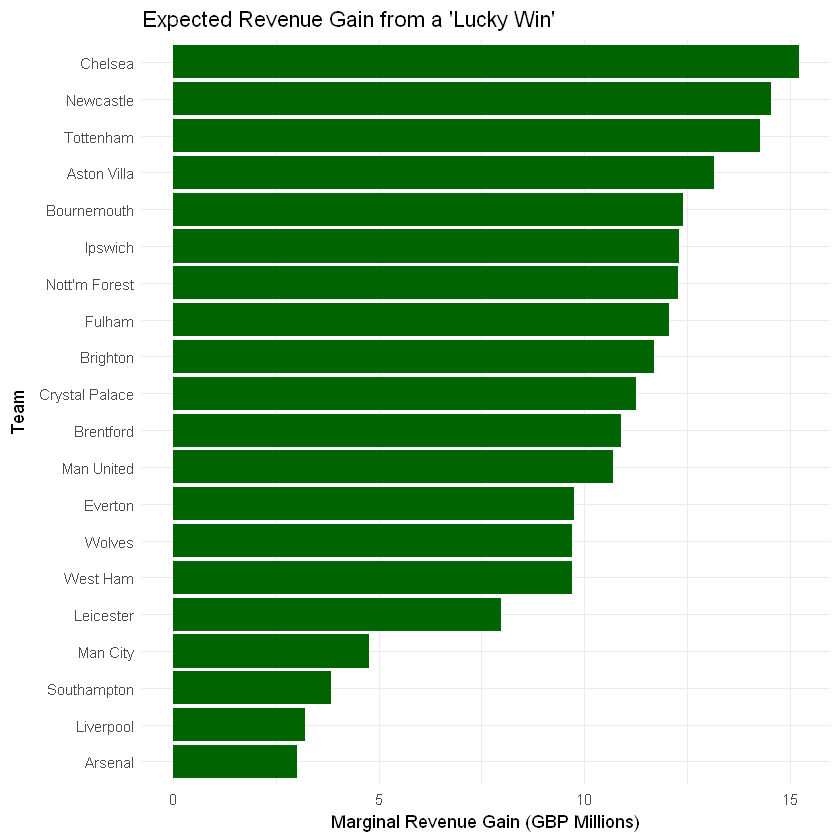

In [25]:
# Reorder the 'team' factor by marginal_revenue_gain
marginal_gain_df$team <- factor(marginal_gain_df$team, levels = marginal_gain_df$team[order(marginal_gain_df$marginal_revenue_gain)])


ggplot(marginal_gain_df, aes(x = team, y = marginal_revenue_gain)) +
  geom_bar(stat = "identity", fill = "darkgreen") +
  coord_flip() +
  labs(
    title = "Expected Revenue Gain from a 'Lucky Win'",
    x = "Team",
    y = "Marginal Revenue Gain (GBP Millions)"
  ) +
  theme_minimal()


### Slightly Harder Way (Taking into Account the Loss as well)

**Method**

Simulates 1,000 full seasons (again). (redefines function to output in list format).

+ For each season:

    + Stores team points and match results.

+ For each team in each season:

    + Randomly selects one match they lost.

+ Flips that to a win (adds 3 points to them, removes 3 from the opponent).

+ Re-ranks all teams.

+ Re-assigns revenue based on new ranks.

+ Stores the difference in revenue from the original.

+ Averages this revenue difference across 1,000 simulations → gives the expected benefit of a lucky win for each team.

+ 20 teams × 1,000 simulations = 20,000 “flip scenarios”

In [26]:

# Create a function that exports simulation in list format (compatability)
    # copy and paste base code and change output line and add _l to note as different function
    # Monte carlo sim function doesnt work bc not compatible with matrix can’t hold list elements

simulate_season_l <- function(alphaList, deltaList, team_names) {
  # Draw a single match score
  draw.score <- function(team1, team2) {
    c(
      rpois(1, exp(alphaList[team1] - deltaList[team2])),
      rpois(1, exp(alphaList[team2] - deltaList[team1]))
    )
  }

  # All matches
  allMatches <- permutations(length(team_names), 2, v = team_names)
  colnames(allMatches) <- c("home", "away")

  # Simulate season
  ScoresMatrix <- matrix(nrow = nrow(allMatches), ncol = 4)
  for (ii in 1:nrow(allMatches)) {
    ScoresMatrix[ii, 1:2] <- allMatches[ii, ]
    ScoresMatrix[ii, 3:4] <- draw.score(allMatches[ii, "home"], allMatches[ii, "away"])
  }
  colnames(ScoresMatrix) <- c("home.team", "away.team", "home.score", "away.score")
  ScoresDF <- as.data.frame(ScoresMatrix, stringsAsFactors = FALSE)
  ScoresDF$home.score <- as.numeric(ScoresDF$home.score)
  ScoresDF$away.score <- as.numeric(ScoresDF$away.score)

  # Add result column
  ScoresDF$winner <- ifelse(
    ScoresDF$home.score > ScoresDF$away.score, "Home",
    ifelse(ScoresDF$home.score < ScoresDF$away.score, "Away", "Draw")
  )
  ScoresDF$winning_team <- ifelse(
    ScoresDF$winner == "Home", ScoresDF$home.team,
    ifelse(ScoresDF$winner == "Away", ScoresDF$away.team, "Draw")
  )

  # Count wins
  win_points <- ScoresDF %>%
    filter(winning_team != "Draw") %>%
    count(winning_team, name = "wins") %>%
    mutate(points = wins * 3)

  # Count draws
  draw_points_home <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(home.team, name = "draws_home") %>%
    rename(team = home.team)

  draw_points_away <- ScoresDF %>%
    filter(winner == "Draw") %>%
    count(away.team, name = "draws_away") %>%
    rename(team = away.team)

  draw_points <- full_join(draw_points_home, draw_points_away, by = "team") %>%
    mutate(
      draws_home = coalesce(draws_home, 0),
      draws_away = coalesce(draws_away, 0),
      total_draws = draws_home + draws_away,
      points = total_draws
    )

  # Combine win and draw points
  points_table <- full_join(
    win_points %>% rename(team = winning_team),
    draw_points, by = "team"
  ) %>%
    mutate(
      points.x = coalesce(points.x, 0),
      points.y = coalesce(points.y, 0),
      total_points = points.x + points.y
    ) %>%
    select(team, total_points)

  # Return total points per team for this season
  out <- setNames(points_table$total_points, points_table$team)
  # ✅ Return both match data and point totals
  return(list(points = out, matches = ScoresDF))
}


In [27]:
num_sims <- 1000

# Run simulations and store full results (list of lists)
season_results <- lapply(1:num_sims, function(i) simulate_season_l(alphaList, deltaList, team_names))


In [28]:
set.seed(8)

# Extract season points matrix
season_sims <- t(sapply(season_results, function(x) x$points))
match_results_list <- lapply(season_results, function(x) x$matches)
# Matrix to store revenue gains per team across simulations
marginal_gain_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(marginal_gain_matrix) <- colnames(season_sims)

for (i in 1:nrow(season_sims)) {
  original_points <- as.numeric(season_sims[i, ])
  names(original_points) <- colnames(season_sims)
  
  original_ranking <- names(sort(original_points, decreasing = TRUE))
  original_revenue <- setNames(revenue_by_position$revenue_million_gbp, original_ranking)
  
  # Use the match results for this simulated season
  sim_scores <- match_results_list[[i]]  # Assuming you stored per-season match results

  for (team in names(original_points)) {
    # Identify all matches the team lost
    losses <- sim_scores %>%
      filter((home.team == team & home.score < away.score) |
             (away.team == team & away.score < home.score))

    # Skip if no losses to flip
    if (nrow(losses) == 0) next

    # Randomly pick one loss to flip
    flip_index <- sample(1:nrow(losses), 1)
    match <- losses[flip_index, ]

    # Create new points vector with the loss flipped to a win
    new_points <- original_points

    # Adjust points: losing team gains 3, winning team loses 3 (adjust for draws if needed)
    if (match$home.team == team) {
      opponent <- match$away.team
      if (match$home.score < match$away.score) {
        new_points[team] <- new_points[team] + 3
        new_points[opponent] <- new_points[opponent] - 3
      }
    } else {
      opponent <- match$home.team
      if (match$away.score < match$home.score) {
        new_points[team] <- new_points[team] + 3
        new_points[opponent] <- new_points[opponent] - 3
      }
    }

    # Re-rank and reassign revenue
    new_ranking <- names(sort(new_points, decreasing = TRUE))
    new_revenue <- setNames(revenue_by_position$revenue_million_gbp, new_ranking)

    # Store revenue change for this team
    marginal_gain_matrix[i, team] <- new_revenue[team] - original_revenue[team]
  }
}

# Compute average revenue gain per team
avg_revenue_gain <- colMeans(marginal_gain_matrix)
avg_revenue_gain_df <- data.frame(team = names(avg_revenue_gain), avg_gain = avg_revenue_gain)
avg_revenue_gain_df <- avg_revenue_gain_df %>% arrange(desc(avg_gain))

# Display results
print(avg_revenue_gain_df)
                          
# Display the table with kableExtra styling
t<- avg_revenue_gain_df %>%
  kable("html", col.names = c("Team", "Average Revenue Gain (GBP Millions)")) %>%
  kable_styling(
    bootstrap_options = c("striped", "hover", "condensed"),
    full_width = F,
    position = "center"
  ) %>%
  column_spec(2, digits = 0)  # Round the average gain to integers
                             



                         team avg_gain
Chelsea               Chelsea  16.2481
Tottenham           Tottenham  15.5821
Newcastle           Newcastle  14.8874
Aston Villa       Aston Villa  14.3023
Bournemouth       Bournemouth  12.8790
Brighton             Brighton  12.4141
Ipswich               Ipswich  12.3122
Fulham                 Fulham  12.0483
Nott'm Forest   Nott'm Forest  11.9725
Man United         Man United  11.7651
Brentford           Brentford  11.4582
Crystal Palace Crystal Palace  11.2037
West Ham             West Ham  10.8102
Wolves                 Wolves  10.7009
Everton               Everton  10.4129
Leicester           Leicester   8.9447
Man City             Man City   5.4124
Southampton       Southampton   3.3835
Liverpool           Liverpool   3.0687
Arsenal               Arsenal   2.7775


ERROR: Error in column_spec(., 2, digits = 0): unused argument (digits = 0)


In [29]:
# Display the table with kableExtra styling
t<- avg_revenue_gain_df %>%
  kable("html", col.names = c("Team", "Average Revenue Gain (GBP Millions)")) %>%
  kable_styling(
    bootstrap_options = c("striped", "hover", "condensed"),
    full_width = F,
    position = "center"
  )                       


# Render in Jupyter Notebook
display_html(as.character(t))

,Team,Average Revenue Gain (GBP Millions)
Chelsea,Chelsea,16.2481
Tottenham,Tottenham,15.5821
Newcastle,Newcastle,14.8874
Aston Villa,Aston Villa,14.3023
Bournemouth,Bournemouth,12.8790
Brighton,Brighton,12.4141
Ipswich,Ipswich,12.3122
Fulham,Fulham,12.0483
Nott'm Forest,Nott'm Forest,11.9725
Man United,Man United,11.7651


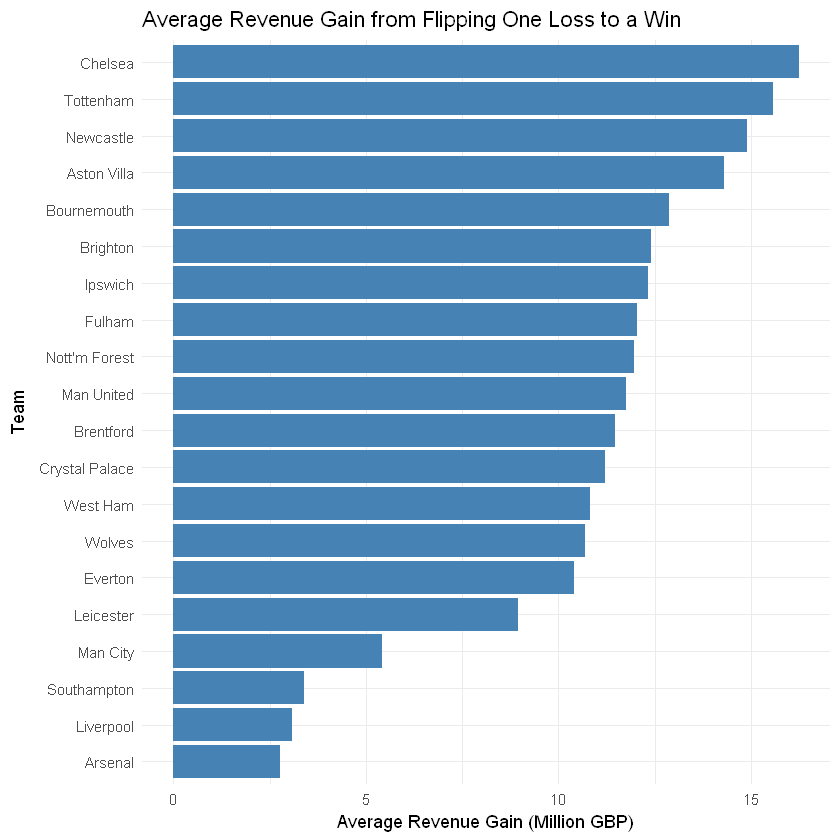

In [30]:
ggplot(avg_revenue_gain_df, aes(x = reorder(team, avg_gain), y = avg_gain)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(
    title = "Average Revenue Gain from Flipping One Loss to a Win",
    x = "Team",
    y = "Average Revenue Gain (Million GBP)"
  ) +
  theme_minimal()

## Where  to Invest in Improvement

Baseline Season: Simulate 1,000 full seasons using each team's original attack (alpha) and defense (delta) values.

   + Assign revenue based on final rank in each season.
   + Compute each team’s average baseline revenue.

Attack Boost (One Team at a Time):

   + For each team, increase its alpha value by 10%.
   + Simulate another 10 seasons with this change (others unchanged).
   + Re-rank teams and assign revenue for each simulation.

Compare the new average revenue to the baseline.

Marginal Effect:

   + Calculate the average revenue gain for each team resulting from the attack improvement.
   
1,000 baseline simulations and 100 simulations for each of 20 teams with the alpha boost

Total: 2100 simulated **full seasons**

**Findings**

revenue is distributed based on relative league position, not on absolute performance metrics like goals scored. So, even if a team scores more goals, it won’t necessarily lead to more points or a higher ranking—especially if the wins don’t come in the right matches or if key games are still lost (since this is still a probabalistic model).

One aspect of performance does not guarantee financial improvement

In [85]:

# If they match, you can assign the row names like this:
rownames(team_estim) <- team_estim$team
rownames(team_estim)

[1] "Arsenal"        "Aston Villa"    "Bournemouth"    "Brentford"     
 [5] "Brighton"       "Chelsea"        "Crystal Palace" "Everton"       
 [9] "Fulham"         "Ipswich"        "Leicester"      "Liverpool"     
[13] "Man City"       "Man United"     "Newcastle"      "Nott'm Forest" 
[17] "Southampton"    "Tottenham"      "West Ham"       "Wolves"

In [86]:
library(rootSolve)
# Extract the list of other teams (excluding Liverpool)
otherTeams <- setdiff(rownames(team_estim), "Liverpool")
alpha <- team_estim['Liverpool','alpha']
otherTeams
alpha

[1] "Arsenal"        "Aston Villa"    "Bournemouth"    "Brentford"     
 [5] "Brighton"       "Chelsea"        "Crystal Palace" "Everton"       
 [9] "Fulham"         "Ipswich"        "Leicester"      "Man City"      
[13] "Man United"     "Newcastle"      "Nott'm Forest"  "Southampton"   
[17] "Tottenham"      "West Ham"       "Wolves"

[1] 0.4485979

In [87]:
# Load rootSolve package if not already done
library(rootSolve)

# Define the alphaShift function
alphaShift <- function(team) {
    # Ensure alphaIn is numeric
    alphaIn <- as.numeric(team_estim[team, "alpha"])
    
    # Ensure otherTeams are correct
    otherTeams <- setdiff(rownames(team_estim), team)
    
    # Define the function to solve for the 10% increase (vectorized)
    fn <- function(x) {
        # We are comparing two values - return the difference as a vector
        result <- mean(exp(x - as.numeric(team_estim[otherTeams, "delta"]))) - 
                 1.1 * mean(exp(alphaIn - as.numeric(team_estim[otherTeams, "delta"])))
        
        # Return the result as a vector with the expected structure
        return(c(result))
    }
    
    # Use multiroot to solve for the value of alphaIn that increases the parameter by 10%
    sol <- multiroot(fn, alphaIn, rtol = 1e-12, atol = 1e-8)
    
    return(sol$root)
}

# Define the deltaShift function
deltaShift <- function(team) {
    # Ensure deltaIn is numeric
    deltaIn <- as.numeric(team_estim[team, "delta"])
    
    # Ensure otherTeams are correct
    otherTeams <- setdiff(rownames(team_estim), team)
    
    # Define the function to solve for the 10% decrease in goals conceded (vectorized)
    fn <- function(x) {
        # We are comparing two values - return the difference as a vector
        result <- mean(exp(as.numeric(team_estim[otherTeams, "alpha"]) - x)) - 
                 0.9 * mean(exp(as.numeric(team_estim[otherTeams, "alpha"]) - deltaIn))
        
        # Return the result as a vector with the expected structure
        return(c(result))
    }
    
    # Use multiroot to solve for the value of deltaIn that decreases goals conceded by 10%
    sol <- multiroot(fn, deltaIn, rtol = 1e-12, atol = 1e-8)
    
    return(sol$root)
}

# Test It on Liverpool
c(alphaShift('Liverpool'), deltaShift('Liverpool'), team_estim['Liverpool', 'alpha'], team_estim['Liverpool', 'delta'])


[1] 0.5439080 0.4801886 0.4485979 0.3748281

In [91]:
set.seed(10)

# Prepare to store results
attack_boost_results <- data.frame(team = character(), avg_revenue_gain = numeric())

# Compute baseline revenue for all teams (without boosts)
baseline_revenue_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(baseline_revenue_matrix) <- colnames(season_sims)

for (i in 1:nrow(season_sims)) {
  points <- as.numeric(season_sims[i, ])
  names(points) <- colnames(season_sims)
  ranking <- names(sort(points, decreasing = TRUE))
  baseline_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
}
baseline_revenue_avg <- colMeans(baseline_revenue_matrix)

# Run 100 simulations for each team with boosted alpha (attack increase)
num_sims <- 500
for (team in team_names) {
   
    # Use the alphaShift function to calculate the shifted alpha for the current team
  shifted_alpha <- alphaShift(team)  # Calculate the shifted alpha
  
  # Update the alpha for the team with the shifted alpha
  boosted_alpha <- alphaList  # Copy the original alpha list
  boosted_alpha[team] <- shifted_alpha  # Replace with shifted alpha for the team

  # Initialize a matrix to store points across all simulations for this team
  boosted_points <- matrix(NA, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_points) <- team_names

  # 🟦 Set up season-level progress bar
  pb <- txtProgressBar(min = 0, max = num_sims, style = 3)

  # Run 100 simulations for the current team
  for (i in 1:num_sims) {
    sim <- simulate_season_l(boosted_alpha, deltaList, team_names)
    boosted_points[i, names(sim$points)] <- sim$points
    setTxtProgressBar(pb, i)
  }
  close(pb)  # ✅

  # Convert the points to revenue after each simulation
  boosted_revenue_matrix <- matrix(0, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_revenue_matrix) <- team_names

  for (i in 1:num_sims) {
    pts <- as.numeric(boosted_points[i, ])
    names(pts) <- colnames(boosted_points)
    ranking <- names(sort(pts, decreasing = TRUE))
    boosted_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
  }

  # Calculate the average revenue for the boosted simulations for the current team
  avg_boosted_revenue <- colMeans(boosted_revenue_matrix)

  # Calculate the revenue gain by subtracting the baseline average from the boosted average
  revenue_gain <- avg_boosted_revenue[team] - baseline_revenue_avg[team]

  # Store the result for this team
  attack_boost_results <- rbind(
    attack_boost_results,
    data.frame(team = team, avg_revenue_gain = revenue_gain)
  )
}

# Sort the results by average revenue gain and display
attack_boost_results <- attack_boost_results %>%
  arrange(desc(avg_revenue_gain))

# Display the results in a formatted table using kableExtra
# Render in Jupyter Notebook
display_html(as.character(attack_boost_results %>%
  kable("html", col.names = c("Team", "Average Revenue Gain (GBP Millions)")) %>%
  kable_styling(
    bootstrap_options = c("striped", "hover", "condensed"),
    full_width = F,
    position = "center")))

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

,Team,Average Revenue Gain (GBP Millions)
Tottenham,Tottenham,16.4399
Chelsea,Chelsea,16.4092
Aston Villa,Aston Villa,15.6387
Fulham,Fulham,14.9805
Wolves,Wolves,14.8123
Newcastle,Newcastle,14.7463
Bournemouth,Bournemouth,12.7506
Brighton,Brighton,10.3855
Brentford,Brentford,10.0994
Crystal Palace,Crystal Palace,10.0300


In [112]:
display_html(as.character(attack_boost_results %>%
  kable("html", col.names = c("Team", "Average Revenue Gain (GBP Millions)")) %>%
  kable_styling(
    bootstrap_options = c("striped", "hover", "condensed"),
    full_width = FALSE,
    position = "center"
  ) %>%
  paste("<div style='text-align: center;'><h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Attack Boost Revenue Effect</h3></div>", .)))


,Team,Average Revenue Gain (GBP Millions)
Tottenham,Tottenham,16.4399
Chelsea,Chelsea,16.4092
Aston Villa,Aston Villa,15.6387
Fulham,Fulham,14.9805
Wolves,Wolves,14.8123
Newcastle,Newcastle,14.7463
Bournemouth,Bournemouth,12.7506
Brighton,Brighton,10.3855
Brentford,Brentford,10.0994
Crystal Palace,Crystal Palace,10.0300


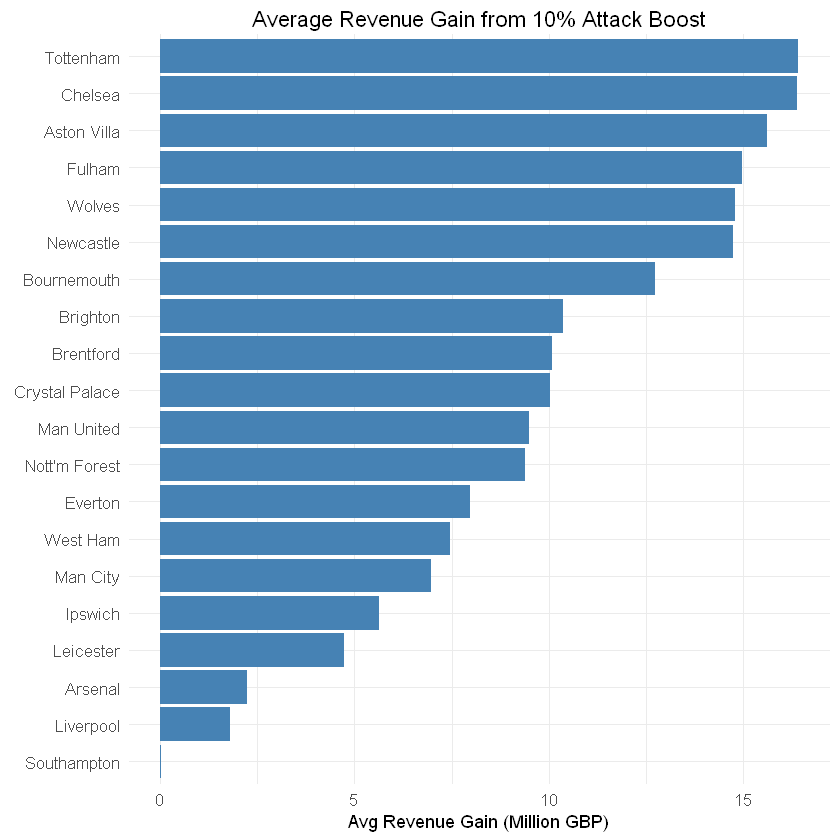

In [108]:
ggplot(attack_boost_results, aes(x = reorder(team, avg_revenue_gain), y = avg_revenue_gain)) +
  geom_bar(stat = "identity", fill = "steelblue") +
 # Add team names
  coord_flip() +
  labs(
    title = "Average Revenue Gain from 10% Attack Boost",
    x = NULL,  # This now correctly labels the x-axis
    y = "Avg Revenue Gain (Million GBP)"  # Remove the 'team' label from the y-axis
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),  # Center the title
    axis.text.x = element_text(size = 10),  # Adjust x-axis label text size if needed
    axis.text.y = element_text(size = 10)   # Adjust y-axis label text size if needed
  )

In [101]:
set.seed(8)

# Prepare to store marginal revenue gains
defense_boost_results <- data.frame(team = character(), avg_revenue_gain = numeric())

# Compute baseline revenue
baseline_revenue_matrix <- matrix(0, nrow = nrow(season_sims), ncol = ncol(season_sims))
colnames(baseline_revenue_matrix) <- colnames(season_sims)

for (i in 1:nrow(season_sims)) {
  points <- as.numeric(season_sims[i, ])
  names(points) <- colnames(season_sims)
  ranking <- names(sort(points, decreasing = TRUE))
  baseline_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
}
baseline_revenue_avg <- colMeans(baseline_revenue_matrix)

# Run simulations for each team with 10% delta decrease (better defense)
for (team in team_names) {
  
    # Use the deltaShift function to get the shifted delta for the team
  shifted_delta <- deltaShift(team)  # Get the shifted delta for the team
  
  # Update the delta for the team with the shifted value
  boosted_delta <- deltaList  # Copy the original delta list
  boosted_delta[team] <- shifted_delta  # Replace with shifted delta for the team

  # Run simulations
  num_sims <- 500
  boosted_points <- matrix(NA, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_points) <- team_names

  # 🟦 Set up season-level progress bar
  pb <- txtProgressBar(min = 0, max = num_sims, style = 3)

  for (i in 1:num_sims) {
    sim <- simulate_season_l(alphaList, boosted_delta, team_names)
    boosted_points[i, names(sim$points)] <- sim$points

    # 🟩 Update progress
    setTxtProgressBar(pb, i)
  }

  close(pb)  # ✅ Close progress bar

  # Convert points to revenue
  boosted_revenue_matrix <- matrix(0, nrow = num_sims, ncol = length(team_names))
  colnames(boosted_revenue_matrix) <- team_names

  for (i in 1:num_sims) {
    pts <- as.numeric(boosted_points[i, ])
    names(pts) <- colnames(boosted_points)
    ranking <- names(sort(pts, decreasing = TRUE))
    boosted_revenue_matrix[i, ranking] <- revenue_by_position$revenue_million_gbp
  }

  # Average gain for that team
  revenue_gain <- colMeans(boosted_revenue_matrix) - baseline_revenue_avg
  defense_boost_results <- rbind(
    defense_boost_results,
    data.frame(team = team, avg_revenue_gain = revenue_gain[team])
  )
}

# Sort and display results
defense_boost_results <- defense_boost_results %>% arrange(desc(avg_revenue_gain))
print(defense_boost_results)


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

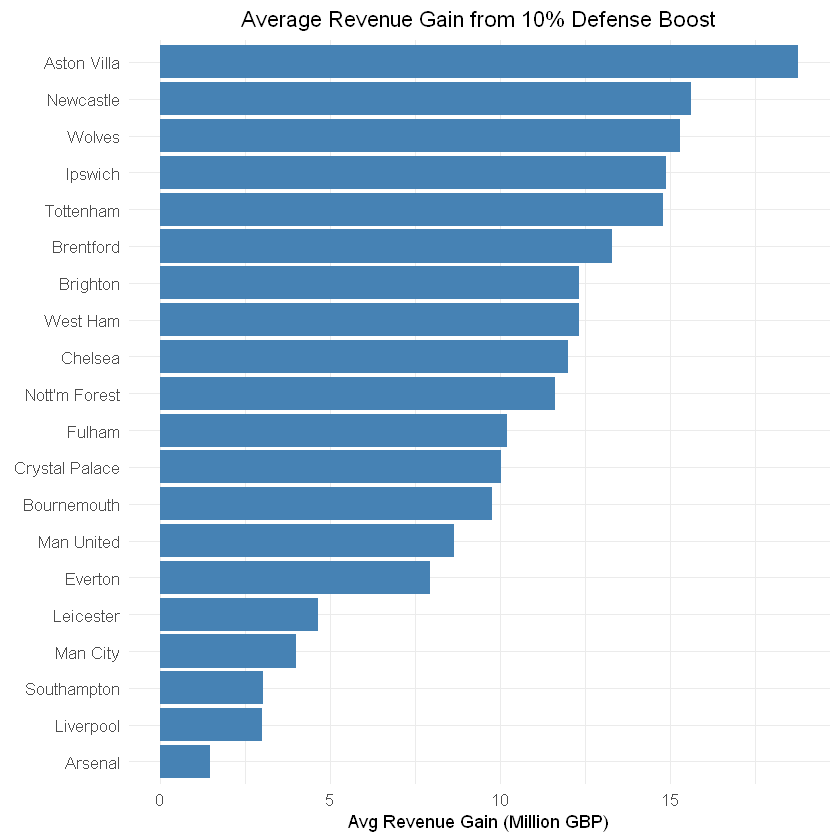

In [110]:
ggplot(defense_boost_results, aes(x = reorder(team, avg_revenue_gain), y = avg_revenue_gain)) +
  geom_bar(stat = "identity", fill = "steelblue") +
 # Add team names
  coord_flip() +
  labs(
    title = "Average Revenue Gain from 10% Defense Boost",
    x = NULL,  # This now correctly labels the x-axis
    y = "Avg Revenue Gain (Million GBP)"  # Remove the 'team' label from the y-axis
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),  # Center the title
    axis.text.x = element_text(size = 10),  # Adjust x-axis label text size if needed
    axis.text.y = element_text(size = 10)   # Adjust y-axis label text size if needed
  )

In [111]:
# Sort and display results as a pretty table
defense_boost_results <- defense_boost_results %>% arrange(desc(avg_revenue_gain))



display_html(as.character(defense_boost_results %>%
  kable("html", col.names = c("Team", "Average Revenue Gain (GBP Millions)")) %>%
  kable_styling(
    bootstrap_options = c("striped", "hover", "condensed"),
    full_width = FALSE,
    position = "center"
  ) %>%
  paste("<div style='text-align: center;'><h3> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Defense Boost Revenue Effect</h3></div>", .)))


,Team,Average Revenue Gain (GBP Millions)
Aston Villa,Aston Villa,18.7691
Newcastle,Newcastle,15.5957
Wolves,Wolves,15.2917
Ipswich,Ipswich,14.8620
Tottenham,Tottenham,14.7705
Brentford,Brentford,13.2752
Brighton,Brighton,12.3057
West Ham,West Ham,12.3037
Chelsea,Chelsea,11.9870
Nott'm Forest,Nott'm Forest,11.6214


In [113]:
# Merge attack and defense results into one data frame
combined_results <- defense_boost_results %>%
  rename(defense_gain = avg_revenue_gain) %>%
  inner_join(attack_boost_results %>% rename(attack_gain = avg_revenue_gain),
             by = "team")

In [114]:
library(tidyr)
# Reshape to long format for ggplot
plot_data <- combined_results %>%
  pivot_longer(cols = c("attack_gain", "defense_gain"),
               names_to = "boost_type",
               values_to = "avg_revenue_gain")


Warning message:
"package 'tidyr' was built under R version 4.2.3"


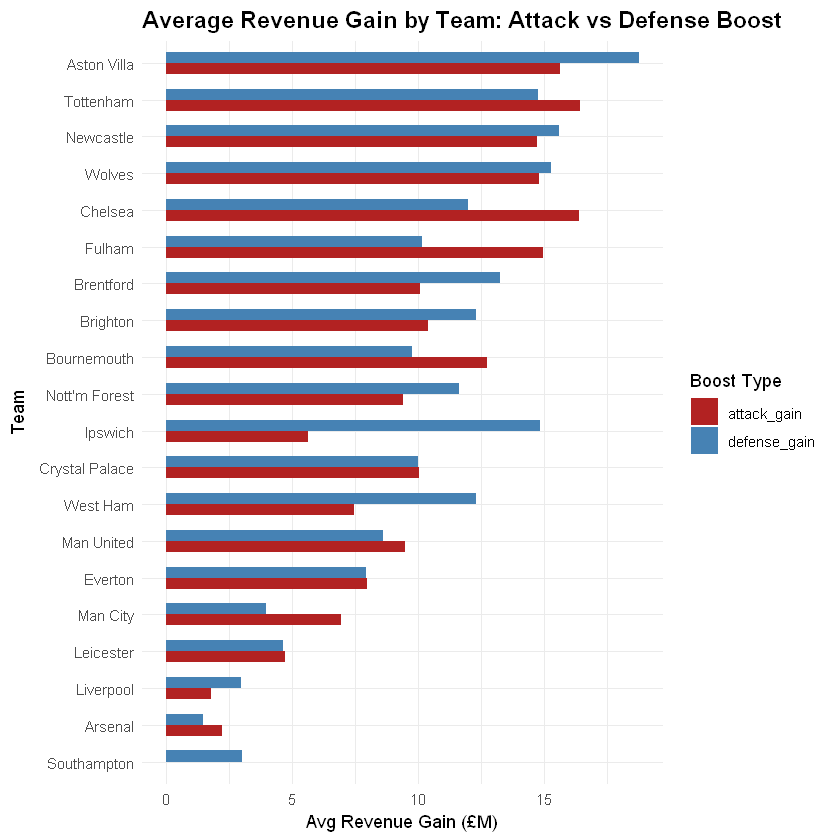

In [141]:
ggplot(plot_data, aes(x = reorder(team, avg_revenue_gain), y = avg_revenue_gain, fill = boost_type)) +
  geom_bar(stat = "identity", 
           position = position_dodge(width = 0.6),  # Smaller dodge width for spacing
           width = 0.6) +                           # Smaller bar width for space between teams
  coord_flip() +
  scale_fill_manual(values = c("attack_gain" = "firebrick", "defense_gain" = "steelblue")) +
  labs(
    title = "Average Revenue Gain by Team: Attack vs Defense Boost",
    x = "Team",
    y = "Avg Revenue Gain (£M)",
    fill = "Boost Type"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.text.y = element_text(size = 9)
  )


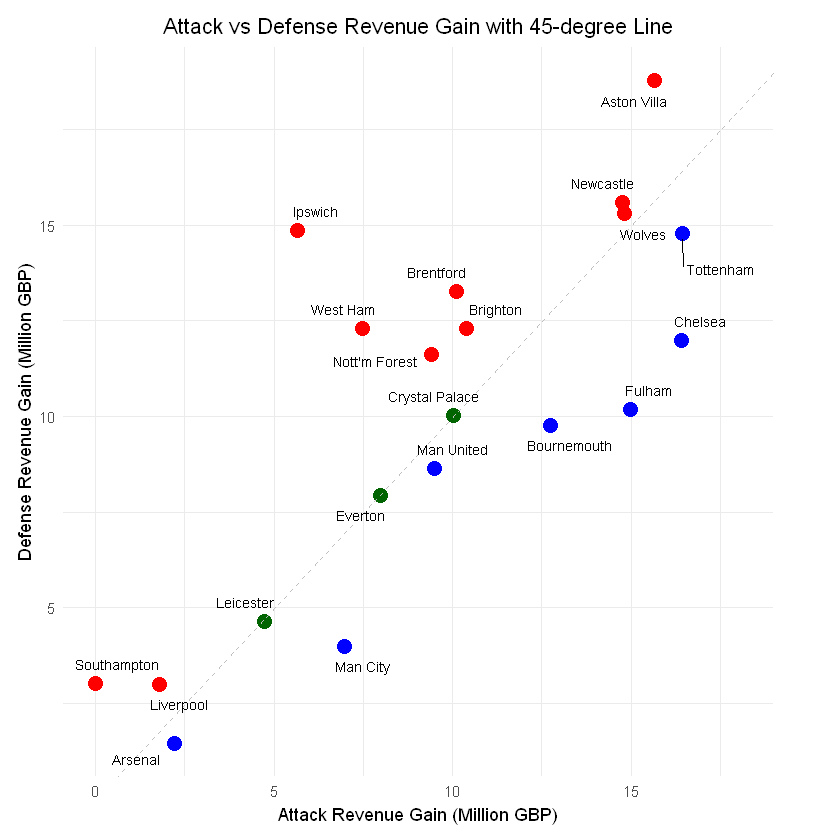

In [140]:
library(ggplot2)
library(dplyr)
library(ggrepel)

# Categorize teams based on position relative to 45-degree line
combined_results <- combined_results %>%
  mutate(position = case_when(
    attack_gain > defense_gain ~ "Below",
    attack_gain < defense_gain ~ "Above",
    attack_gain == defense_gain ~ "On Line"
  ))

# Custom color logic: green for Everton, Leicester, Crystal Palace
combined_results <- combined_results %>%
  mutate(point_color = case_when(
    team %in% c("Everton", "Leicester", "Crystal Palace") ~ "Special",
    position == "Above" ~ "Above",
    position == "Below" ~ "Below",
    TRUE ~ "On Line"
  ))

# Create the plot
ggplot(combined_results, aes(x = attack_gain, y = defense_gain)) +
  geom_point(aes(color = point_color), size = 4) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  geom_text_repel(
    aes(label = team),
    size = 3,
    max.overlaps = Inf,
    box.padding = 0.5,
    point.padding = 0.3
  ) +
  labs(
    title = "Attack vs Defense Revenue Gain with 45-degree Line",
    x = "Attack Revenue Gain (Million GBP)",
    y = "Defense Revenue Gain (Million GBP)"
  ) +
  scale_color_manual(
    values = c("Above" = "red", "Below" = "blue", "On Line" = "gray", "Special" = "darkgreen")
  ) +
  xlim(0, max(combined_results$attack_gain) * 1.1) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5),
    legend.position = "none",
    plot.margin = margin(10, 40, 10, 10)
  )
